In [96]:
import os, sys
import numpy as np
import pandas as pd
import SimpleITK as sitk
from scipy import ndimage as ndi
from skimage import filters
from skimage import measure
import skimage
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline

In [543]:
import SimpleITK as sitk

# ref https://gist.github.com/pangyuteng/7f54dbfcd67fb9d43a85f8c6818fca7b
def imread(fpath):
    if os.path.isdir(fpath):
        dicom_names = [os.path.join(fpath,x) for x in os.listdir(fpath)]
        mylist = []
        for x in dicom_names:
            ds = pydicom.dcmread(x)
            mylist.append( (ds.InstanceNumber,x))
        
        dicom_names = [x[1] for x in sorted(mylist,key=lambda x: x[0])]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()
    return img

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)

# ref https://gist.github.com/mrajchl/ccbd5ed12eb68e0c1afc5da116af614a
def resample_img(itk_image,origin,direction):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    out_spacing=[1.0, 1.0, 1.0]
    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(direction)
    resample.SetOutputOrigin(origin)
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    sampler = None
    if sampler == 'nearest':
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


In [544]:
import os
import requests
local_filename = 'img.zip'
if not os.path.exists(local_filename):
    uid = "1.3.6.1.4.1.14519.5.2.1.6279.6001.113679818447732724990336702075"
    r=requests.get(f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getImage?SeriesInstanceUID={uid}")
    if r.status_code == 200:
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    del r

In [101]:
# !mkdir -p img && unzip img.zip -d img

In [546]:
#itk_image = imread('img')
itk_image = imread('image.nii.gz')

(0.609375, 0.609375, 1.25) (-146.6999969482422, -152.1999969482422, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (512, 512, 241)


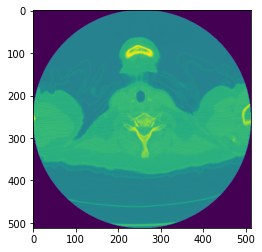

In [547]:
arr = sitk.GetArrayFromImage(itk_image)    
spacing = itk_image.GetSpacing()
origin = itk_image.GetOrigin()
direction = itk_image.GetDirection()
size = itk_image.GetSize()

#imwrite('image.nii.gz',arr,spacing,origin,direction)

print(spacing,origin,direction,size)

plt.imshow(arr[0,:,:].squeeze())

In [548]:
# create rof.nii.gz 

In [549]:
roi_image = imread('lof.nii.gz')
arr = sitk.GetArrayFromImage(roi_image)    
print(np.sum(arr))

4534


In [573]:
itk_image = imread('image.nii.gz')
roi_image = imread('lof.nii.gz')

spacing = itk_image.GetSpacing()
spacing = (1,1,1)
origin = itk_image.GetOrigin()
direction = itk_image.GetDirection()
size = itk_image.GetSize()

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
resample.SetInterpolator(sitk.sitkBSpline)

new_img = resample.Execute(itk_image)
arr = sitk.GetArrayFromImage(new_img)

spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)

resample.SetInterpolator(sitk.sitkNearestNeighbor)
new_roi = resample.Execute(roi_image)

spacing = new_roi.GetSpacing()
origin = new_roi.GetOrigin()
direction = new_roi.GetDirection()
size = new_roi.GetSize()

print(spacing,origin,direction,size)


(1.0, 1.0, 1.0) (-146.6999969482422, -152.1999969482422, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (512, 512, 241)
(1.0, 1.0, 1.0) (-146.6999969482422, -152.1999969482422, 7.5) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (512, 512, 241)


In [574]:
arr = sitk.GetArrayFromImage(new_roi).astype(int)
_zs,_xs,_ys = np.where(arr==1)
ps = []
for x,y,z in zip(_xs,_ys,_zs):
    #p = new_roi.TransformContinuousIndexToPhysicalPoint((float(x),float(y),float(z)))
    p = (float(x),float(y),float(z))
    ps.append(p)
ps = np.array(ps)
print(ps.shape)

(1874, 3)


solution:
-0.307274 x + 0.214111 y + 152.653501 = z


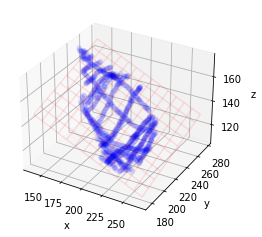

In [575]:
xs = ps[:,0]
ys = ps[:,1]
zs = ps[:,2]

# do fit
tmp_A = []
tmp_b = []
for i in range(len(xs)):
    tmp_A.append([xs[i], ys[i], 1])
    tmp_b.append(zs[i])
b = np.matrix(tmp_b).T
A = np.matrix(tmp_A)
fit = (A.T * A).I * A.T * b
errors = b - A * fit
residual = np.linalg.norm(errors)

print("solution:")
print("%f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))
#print("errors:")
#print(errors)
#print("residual:")
#print(residual)

# plot plane
X,Y = np.meshgrid(np.arange(np.min(xs),np.max(xs)+20,10),
                  np.arange(np.min(ys),np.max(ys)+20,10))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
        
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(xs, ys, zs, color='b',alpha=0.05)

ax.plot_wireframe(X,Y,Z, color='r',alpha=0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [576]:
print("%f x + %f y + %f = z" % (fit[0], fit[1], fit[2]))

-0.307274 x + 0.214111 y + 152.653501 = z


In [577]:
# https://web.ma.utexas.edu/users/m408m/Display12-5-4.shtml
z_vec = np.array([fit[0,0], fit[1,0], -1])
z_vec = z_vec / (np.linalg.norm(z_vec) + 1e-16)
print(z_vec)

[-0.28775556  0.20051059 -0.93647864]


In [578]:
np.min(X),np.max(X),np.min(Y),np.max(Y)

(137.0, 267.0, 177.0, 277.0)

In [579]:
c00 = (X[0,0],Y[0,0],Z[0,0])
c10 = (X[-1,0],Y[-1,0],Z[-1,0])
c01 = (X[0,-1],Y[0,-1],Z[0,-1])
c11 = (X[-1,-1],Y[-1,-1],Z[-1,-1])
origin = c00
print(origin)
x_vec = np.array(c10)-np.array(c00)
x_vec = x_vec / (np.linalg.norm(x_vec) + 1e-16)
y_vec = np.array(c01)-np.array(c00)
y_vec = y_vec / (np.linalg.norm(y_vec) + 1e-16)

print(x_vec)
print(y_vec)
z_vec = np.cross(x_vec,y_vec)
print(z_vec)

direction = tuple(x_vec)+tuple(y_vec)+tuple(z_vec)

xsize = int(np.sqrt(np.sum(np.array(c00)-np.array(c01))**2))
ysize = int(np.sqrt(np.sum(np.array(c00)-np.array(c10))**2))

#origin = np.array(c00)-np.array([0,0,-20])
origin = c11
origin = tuple(list(origin))
spacing = (1,1,1)
zsize = 40
size = (xsize,ysize,zsize)
print(size)


(137.0, 177.0, 148.45464803919882)
[0.         0.97783736 0.20936596]
[ 0.95589133  0.         -0.29372057]
[-0.28721095  0.2001311  -0.93470625]
(90, 121, 40)


In [580]:
for p in [c00,c01,c10,c11]:
    print(p)

(137.0, 177.0, 148.45464803919882)
(267.0, 177.0, 108.50902538729106)
(137.0, 277.0, 169.86577091838438)
(267.0, 277.0, 129.92014826647662)


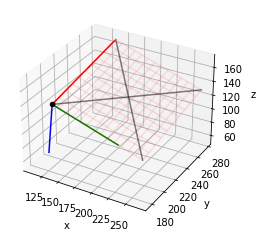

In [581]:
# plot raw data
plt.figure()
ax = plt.subplot(111, projection='3d')

ax.plot([c00[0],c11[0]],[c00[1],c11[1]],[c00[2],c11[2]],color='k',alpha=0.5)
ax.plot([c01[0],c10[0]],[c01[1],c10[1]],[c01[2],c10[2]],color='k',alpha=0.5)

c = 100
ax.plot([c00[0],c00[0]+c*x_vec[0]],[c00[1],c00[1]+c*x_vec[1]],[c00[2],c00[2]+c*x_vec[2]],color='r',alpha=1)
ax.plot([c00[0],c00[0]+c*y_vec[0]],[c00[1],c00[1]+c*y_vec[1]],[c00[2],c00[2]+c*y_vec[2]],color='g',alpha=1)
ax.plot([c00[0],c00[0]+c*z_vec[0]],[c00[1],c00[1]+c*z_vec[1]],[c00[2],c00[2]+c*z_vec[2]],color='b',alpha=1)


ax.scatter(c00[0],c00[1],c00[2],color='k',alpha=1)


ax.plot_wireframe(X,Y,Z, color='r',alpha=0.1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.axis('equal')
plt.show()

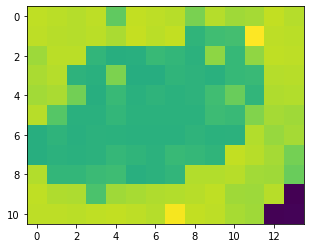

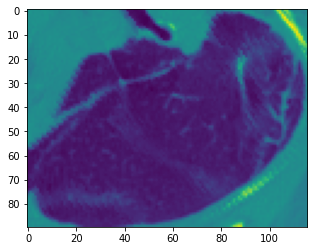

In [582]:
arr = sitk.GetArrayFromImage(new_img)

oblique = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        x,y,z = int(X[r,c]),int(Y[r,c]),int(Z[r,c])
        oblique[r,c]=arr[z,x,y]
plt.figure(0)
plt.imshow(oblique)

hdX,hdY = np.meshgrid(np.arange(np.min(xs),np.max(xs),1),
                  np.arange(np.min(ys),np.max(ys),1))

hdZ = np.zeros(hdX.shape)
for r in range(hdX.shape[0]):
    for c in range(hdX.shape[1]):
        hdZ[r,c] = fit[0] * hdX[r,c] + fit[1] * hdY[r,c] + fit[2]

hdoblique = np.zeros(hdX.shape)
for r in range(hdX.shape[0]):
    for c in range(hdX.shape[1]):
        x,y,z = int(hdX[r,c]),int(hdY[r,c]),int(hdZ[r,c])
        hdoblique[r,c]=arr[z,x,y]
plt.figure(1)
plt.imshow(hdoblique)

In [583]:
hdX.shape

(90, 116)

1386.0
158869074


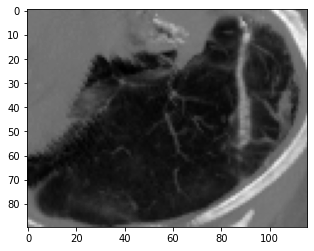

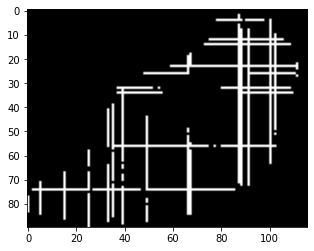

In [597]:
arr_roi = sitk.GetArrayFromImage(new_roi)
arr_img = sitk.GetArrayFromImage(new_img)

myshape = hdX.shape
myshape = list(myshape+(10,))
roi_oblique = np.zeros(myshape)
img_oblique = np.zeros(myshape)
for o in range(myshape[2]):
    for r in range(myshape[0]):
        for c in range(myshape[1]):
            x,y,z = int(hdX[r,c]),int(hdY[r,c]),int(hdZ[r,c])
            roi_oblique[r,c,o]=arr_roi[z+o-5,x,y]
            img_oblique[r,c,o]=arr_img[z+o-5,x,y]
            
plt.figure(0)
kwargs = dict(cmap='gray')#,vmin=-1024,vmax=-500)
plt.imshow(np.max(img_oblique,axis=-1),**kwargs)
plt.figure(1)
plt.imshow(np.max(roi_oblique,axis=-1),**kwargs)

print(np.sum(roi_oblique))
print(np.sum(sitk.GetArrayFromImage(new_roi)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


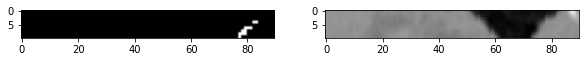

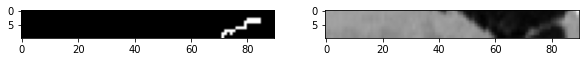

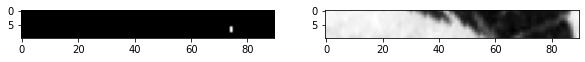

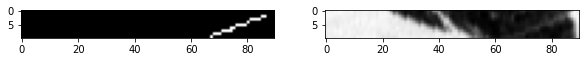

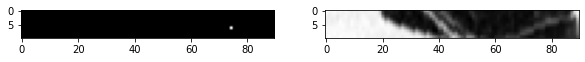

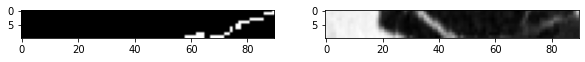

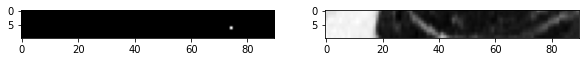

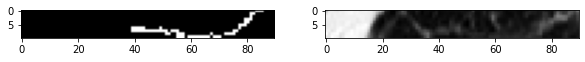

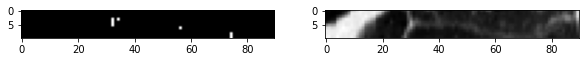

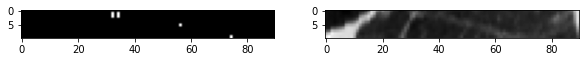

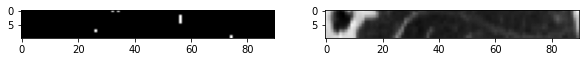

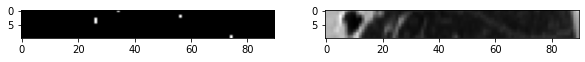

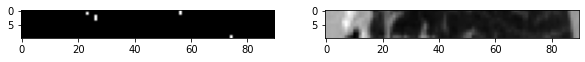

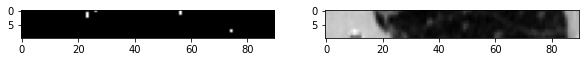

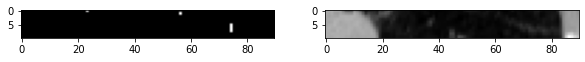

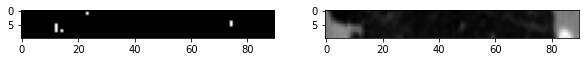

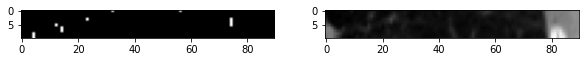

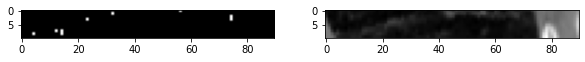

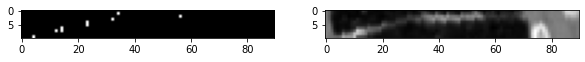

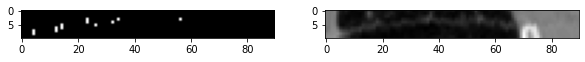

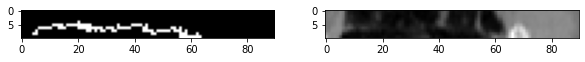

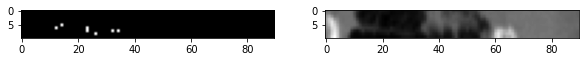

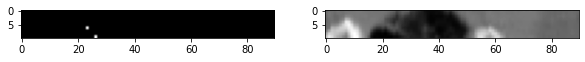

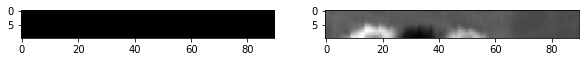

In [598]:
kwargs = {'cmap':'gray'}
for o in np.arange(0,hdoblique.shape[1],5):
    plt.figure(o,figsize=(10,5))
    plt.subplot(121)
    plt.imshow(roi_oblique[:,o,:].T,**kwargs)
    plt.subplot(122)
    plt.imshow(img_oblique[:,o,:].T,**kwargs)

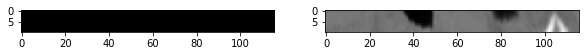

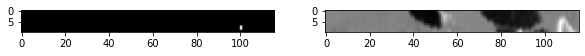

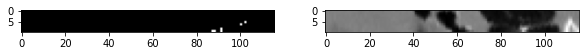

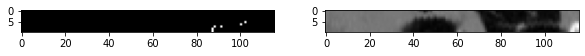

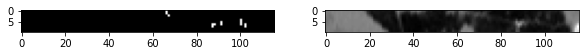

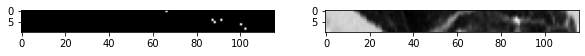

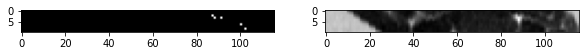

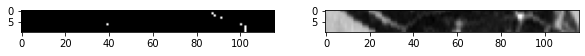

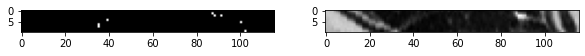

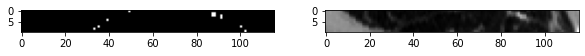

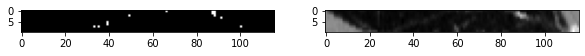

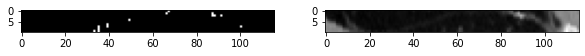

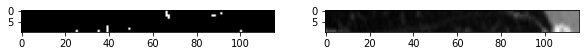

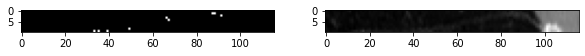

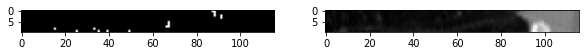

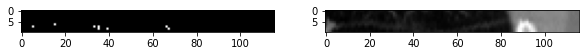

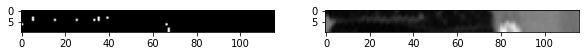

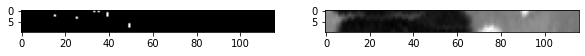

In [599]:
kwargs = {'cmap':'gray'}
for o in np.arange(0,hdoblique.shape[0],5):
    plt.figure(o,figsize=(10,5))
    plt.subplot(121)
    plt.imshow(roi_oblique[o,:,:].T,**kwargs)
    plt.subplot(122)
    plt.imshow(img_oblique[o,:,:].T,**kwargs)

(1.0, 1.0, 1.0) (267.0, 277.0, 129.92014826647662) (0.0, 0.9778373564418616, 0.2093659579463468, 0.9558913256004599, 0.0, -0.2937205706820605, -0.287210946368341, 0.20013110307694357, -0.9347062468708605) (90, 121, 40)
(1.0, 1.0, 1.0) (267.0, 277.0, 129.92014826647662) (0.0, 0.9778373564418616, 0.2093659579463468, 0.9558913256004599, 0.0, -0.2937205706820605, -0.287210946368341, 0.20013110307694357, -0.9347062468708605) (90, 121, 40)


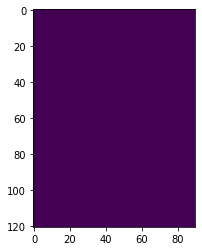

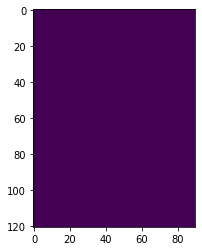

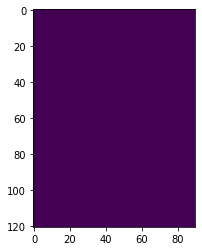

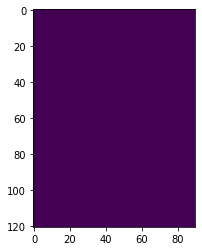

In [571]:

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
#resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
resample.SetDefaultPixelValue(-2000)
resample.SetInterpolator(sitk.sitkBSpline)
new_img = resample.Execute(itk_image)


arr = sitk.GetArrayFromImage(new_img)
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)

print(spacing,origin,direction,size)
for i in np.arange(0,arr.shape[0],10):
    plt.figure(i)
    plt.imshow(arr[i,:,:].squeeze(),vmin=-1024,vmax=1024)

In [399]:
size = new_img.GetSize()
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()

arr=np.zeros(arr.shape)
img = sitk.GetImageFromArray(arr)
img.SetSpacing(spacing)
img.SetOrigin(origin)
img.SetDirection(direction)
writer = sitk.ImageFileWriter()    
writer.SetFileName('oblique.nii.gz')
writer.SetUseCompression(True)
writer.Execute(img)


(1.0, 1.0, 1.0) (66.33984375, -39.16015625, 1132.9273289466294) (0.0, 0.9995943734574947, -0.028479616432085825, 0.518870539811327, 0.0, 0.854852831144579, 0.8545060801463309, -0.014777233951735911, -0.5186600721482555) (238, 97, 40)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


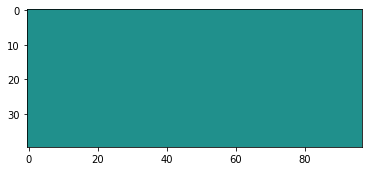

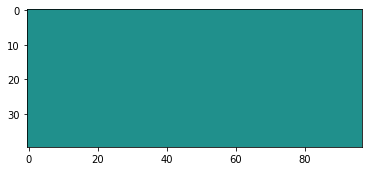

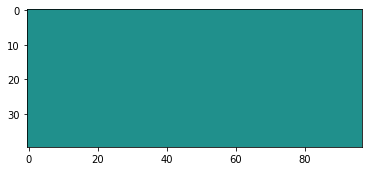

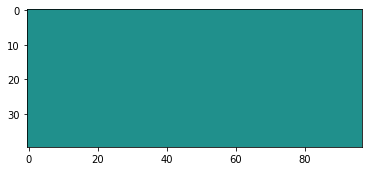

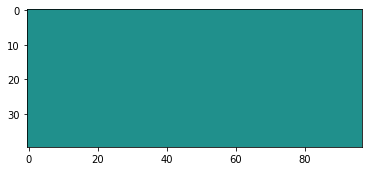

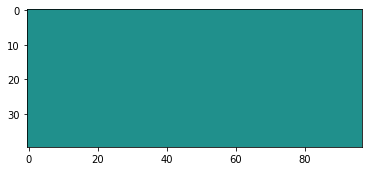

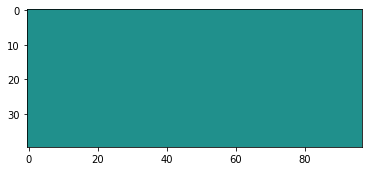

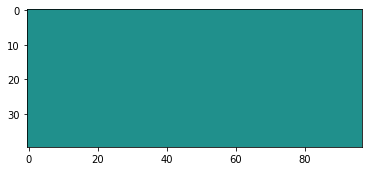

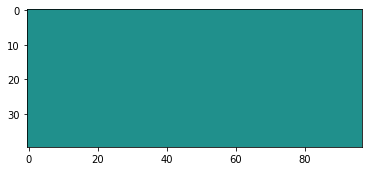

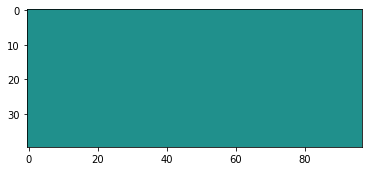

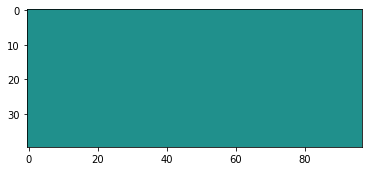

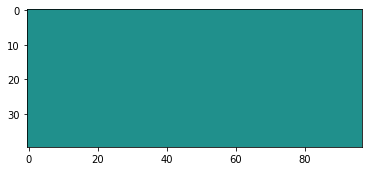

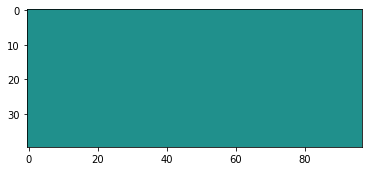

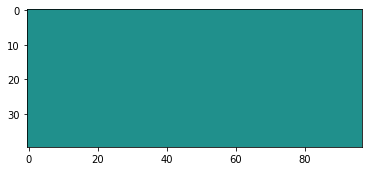

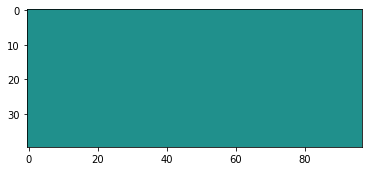

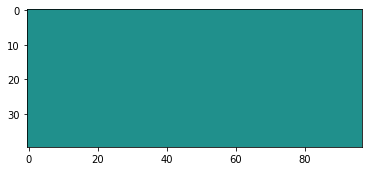

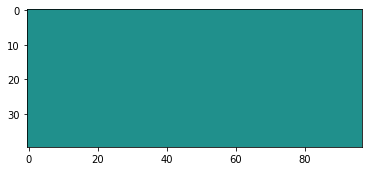

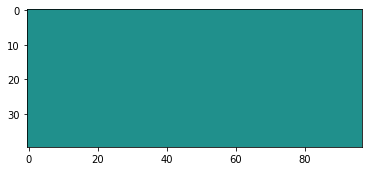

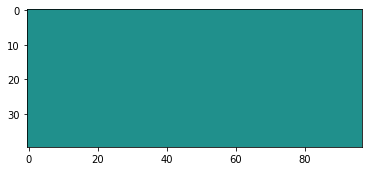

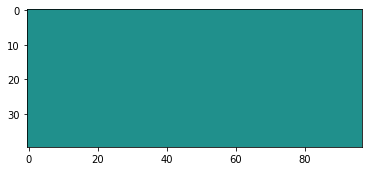

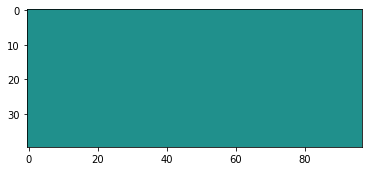

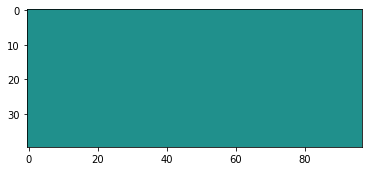

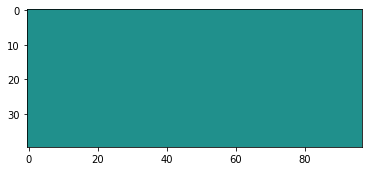

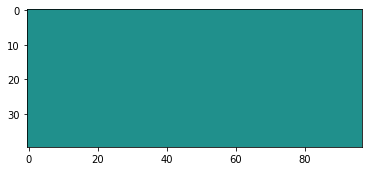

In [400]:
print(spacing,origin,direction,size)
for i in np.arange(0,arr.shape[2],10):
    plt.figure(i)
    plt.imshow(arr[:,:,i].squeeze(),vmin=-1024,vmax=1024)

(1.0, 1.0, 1.0) (-23.66015625, -139.16015625, 1007.4990843825564) (0.0, 0.9995943734574947, -0.028479616432085825, 0.518870539811327, 0.0, 0.854852831144579, 0.8545060801463309, -0.014777233951735911, -0.5186600721482555) (238, 97, 40)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


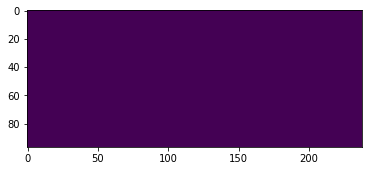

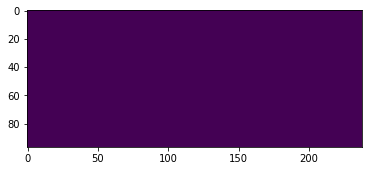

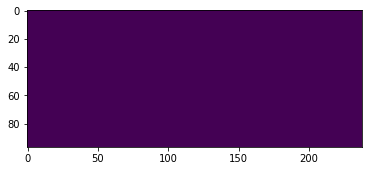

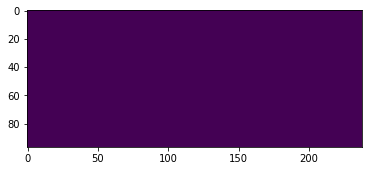

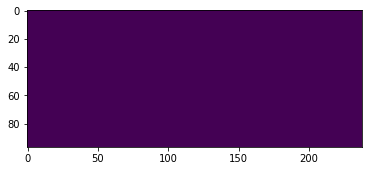

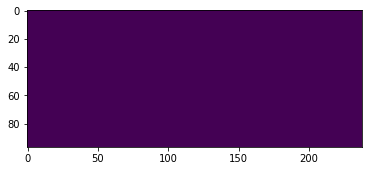

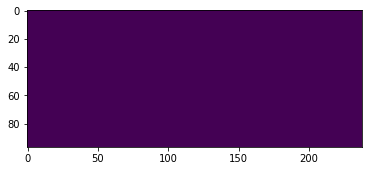

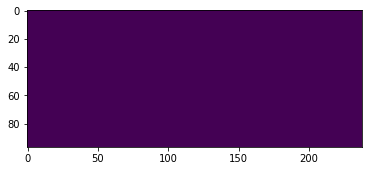

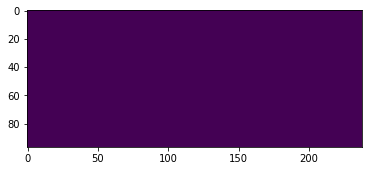

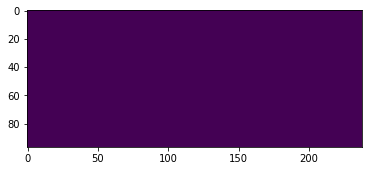

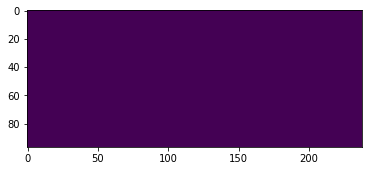

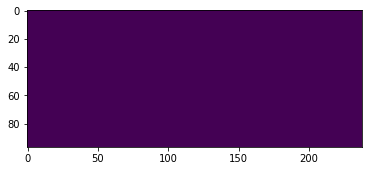

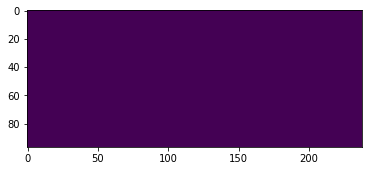

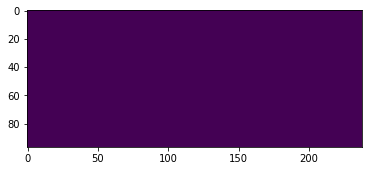

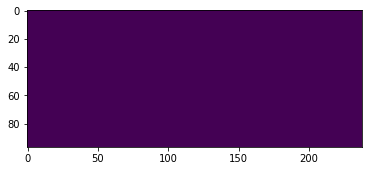

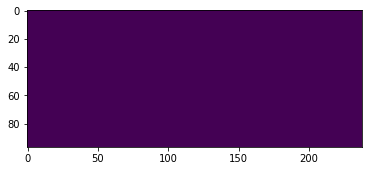

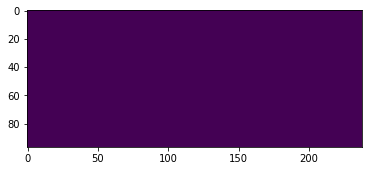

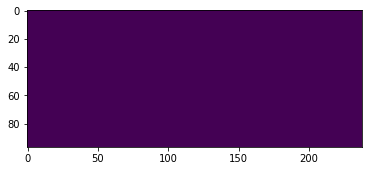

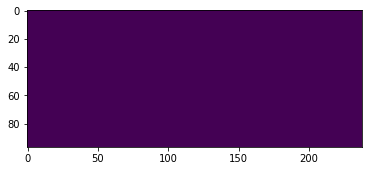

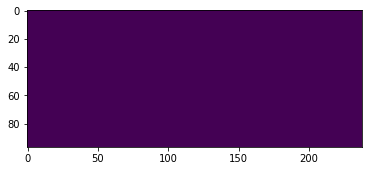

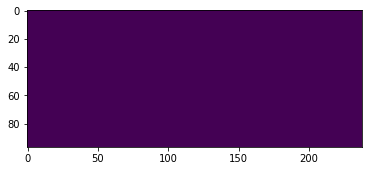

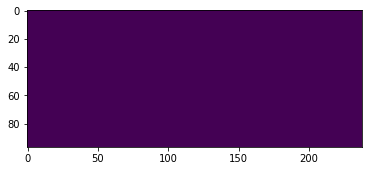

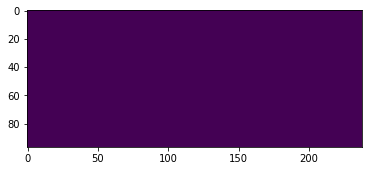

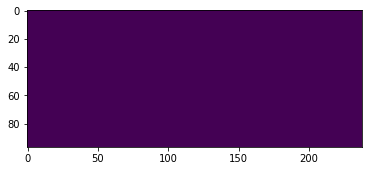

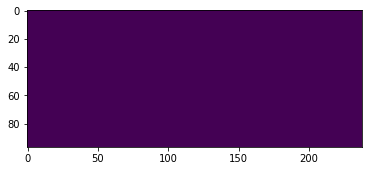

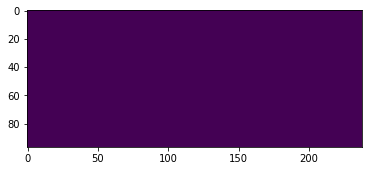

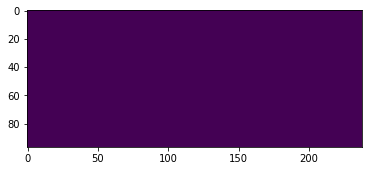

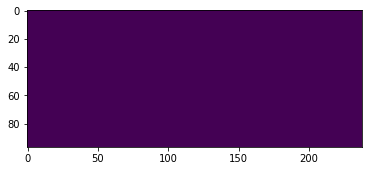

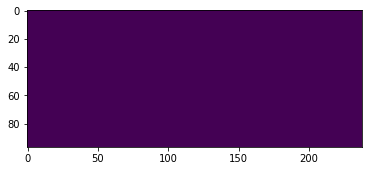

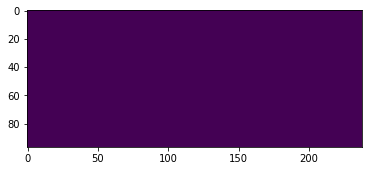

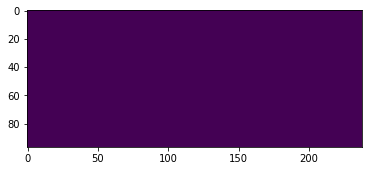

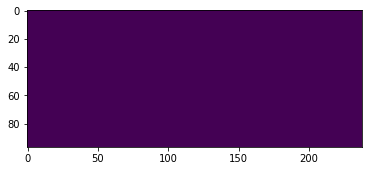

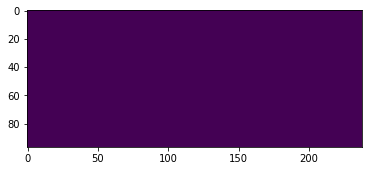

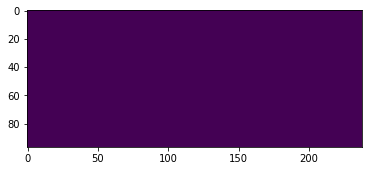

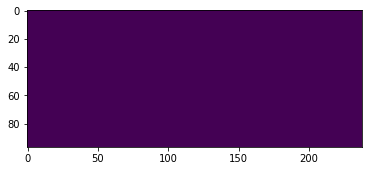

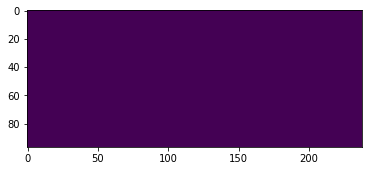

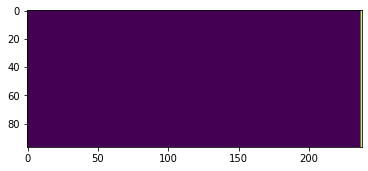

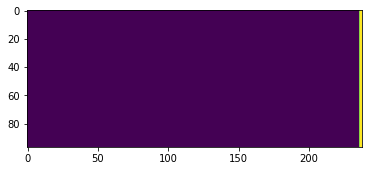

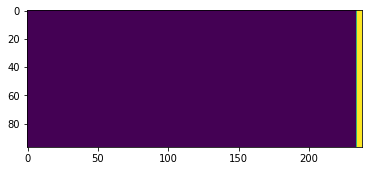

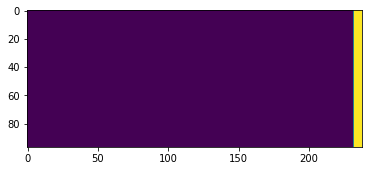

In [382]:

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(spacing)
resample.SetSize(size)
resample.SetOutputDirection(direction)
resample.SetOutputOrigin(origin)
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(-1)
resample.SetInterpolator(sitk.sitkNearestNeighbor)
new_roi = resample.Execute(roi_image)

arr = sitk.GetArrayFromImage(new_roi)
spacing = new_img.GetSpacing()
origin = new_img.GetOrigin()
direction = new_img.GetDirection()
size = new_img.GetSize()

print(spacing,origin,direction,size)
for i in range(zsize):
    plt.figure(i)
    plt.imshow(arr[i,:,:].squeeze())